###GitHub has has 25MB size restriction. Thus several outputs have been deleted. The full Jupyter file can be downloaded from Drive.

In [1]:
opt = {'save_dir':'/home/mohit/Music/jupyter_files'}

opt.update({'exp_name':'low_light_Ourmodel_ourloss'})
opt.update({'dataroot':'/home/mohit/Music/jupyter_files'})

opt.update({'gpu':"1"})
opt.update({'batch_size':1}) # 9*5*3 = 135

opt.update({'epochs':10000}) # this is here total number of iterations
opt['when_reduce']=20000
opt.update({'lr':1e-4}) # initial lr for adam

opt.update({'patch':180})
opt.update({'views_beg':5})
opt.update({'views_end':12})
opt['indv_blocks'] = 6
opt['hidd_blocks'] = 4

opt['text_prnt_freq']=500
opt.update({'print_freq':2000})
opt.update({'save_freq':20000})


opt.update({'normalizeMean':[0.5,0.5,0.5]})
opt.update({'normalizeStd':[1,1,1]})

In [2]:
import random
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torchvision.transforms.functional as Ft

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import skimage
import time
from skimage.measure import compare_ssim as _SSIM
from skimage.measure import compare_psnr as _PSNR
from skimage.measure import compare_nrmse as _NRMSE
from torch.autograd import Variable
from math import exp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
##os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]=opt['gpu']

In [3]:
print(opt)

{'save_dir': '/home/mohit/Music/jupyter_files', 'exp_name': 'low_light_Ourmodel_ourloss', 'dataroot': '/home/mohit/Music/jupyter_files', 'gpu': '1', 'batch_size': 1, 'epochs': 10000, 'when_reduce': 20000, 'lr': 0.0001, 'patch': 180, 'views_beg': 5, 'views_end': 12, 'indv_blocks': 6, 'hidd_blocks': 4, 'text_prnt_freq': 500, 'print_freq': 2000, 'save_freq': 20000, 'normalizeMean': [0.5, 0.5, 0.5], 'normalizeStd': [1, 1, 1]}


In [4]:
trns = transforms.Compose([transforms.ToTensor()])

print(trns)

Compose(
    ToTensor()
)


#### UNET PARTS

In [ ]:
class get_data(Dataset):
    """Loads the Data."""

    def __init__(self, opt, transforms=None):
        
        self.root_dir = opt['dataroot']
        self.patch = opt['patch']
        self.transforms = transforms
        self.view_beg = opt['views_beg']
        self.view_end = opt['views_end']
        
        self.files_op = sorted(os.walk(os.path.join(self.root_dir,'new_dataset/merged/train/1')))
        self.files_op = sorted(self.files_op[0][2])
        self.files_ip = sorted(os.walk(os.path.join(self.root_dir,'new_dataset/merged/train/1_20')))
        self.files_ip = sorted(self.files_ip[0][2])
        
        
    def __len__(self):
        return len(self.files_op)

    def __getitem__(self, idx):
        
        ## load images
        self.img_gt = Image.open(os.path.join(self.root_dir,'new_dataset/merged/train/1',self.files_op[idx])).convert('RGB')
        self.img = Image.open(os.path.join(self.root_dir,'new_dataset/merged/train/1_20',self.files_ip[idx])).convert('RGB')
                
        #gamma = np.random.uniform(2,3,1)[0]
        
        #self.img = transforms.functional.adjust_gamma(self.img_gt, gamma, gain=1)
        
        #transforms.functional.to_pil_image(pic, mode=None)
        
        #self.img+=torch.Tensor(self.img.size()).normal_(0,np.random.uniform(0,0.01,1)[0])
        
       
        
        ## patch generation
        width, height = self.img.size
        
        w = width//15
        h = height//15
        
        th = self.patch
        tw = self.patch
        
        deli = 0#random.randint(-8, 8)
        delj = 0#random.randint(-8, 8)
        
        i = random.randint(0, h - th-0)+deli # h_fixed
        j = random.randint(0, w - tw-0)+delj
        
        n_views = self.view_end-self.view_beg+1
        
        if random.randint(0, 100)>50:
            flip_flag = True
        else:
            flip_flag = False
            
        if random.randint(0, 100)<20:
            v_flag = True
        else:
            v_flag = False
            
        if random.randint(0, 100)>50:
            color_jitter_flag = True
            jitter_order = np.random.permutation(3)
        else:
            color_jitter_flag = False
        

        for ii in range(self.view_beg,self.view_end+1):
            for jj in range(self.view_beg,self.view_end+1):
                
                img_ip_small_c = Ft.crop(self.img,(i+(h*(jj-1))),(j+(w*(ii-1))),th,tw)
                img_ip_small_n = Ft.crop(self.img,(i+(h*(jj))),(j+(w*(ii-1))),th,tw)
                img_ip_small_e = Ft.crop(self.img,(i+(h*(jj-2))),(j+(w*(ii-1))),th,tw)
                img_ip_small_s = Ft.crop(self.img,(i+(h*(jj-1))),(j+(w*(ii))),th,tw)
                img_ip_small_w = Ft.crop(self.img,(i+(h*(jj-1))),(j+(w*(ii-2))),th,tw)
                    
                img_op_small = Ft.crop(self.img_gt,(i+(h*(jj-1))),(j+(w*(ii-1))),th,tw)
                    
                if flip_flag:
                    img_ip_small_c = Ft.hflip(img_ip_small_c)
                    img_ip_small_n = Ft.hflip(img_ip_small_n)
                    img_ip_small_e = Ft.hflip(img_ip_small_e)
                    img_ip_small_s = Ft.hflip(img_ip_small_s)
                    img_ip_small_w = Ft.hflip(img_ip_small_w)
                    
                    img_op_small = Ft.hflip(img_op_small)
                    
                if v_flag:
                    img_ip_small_c = Ft.vflip(img_ip_small_c)
                    img_ip_small_n = Ft.vflip(img_ip_small_n)
                    img_ip_small_e = Ft.vflip(img_ip_small_e)
                    img_ip_small_s = Ft.vflip(img_ip_small_s)
                    img_ip_small_w = Ft.vflip(img_ip_small_w)
                    
                    img_op_small = Ft.vflip(img_op_small)
                
                img_ip_small_c = self.transforms(img_ip_small_c) # 3,H,W
                img_ip_small_w = self.transforms(img_ip_small_w)
                img_ip_small_s = self.transforms(img_ip_small_s)
                img_ip_small_e = self.transforms(img_ip_small_e)
                img_ip_small_n = self.transforms(img_ip_small_n)
                
                img_op_small = self.transforms(img_op_small) 

                if color_jitter_flag:
                    img_ip_small_c = img_ip_small_c[jitter_order,...]
                    img_ip_small_w = img_ip_small_w[jitter_order,...]
                    img_ip_small_s = img_ip_small_s[jitter_order,...]
                    img_ip_small_e = img_ip_small_e[jitter_order,...]
                    img_ip_small_n = img_ip_small_n[jitter_order,...]

                    img_op_small = img_op_small[jitter_order,...]

                img_ip_small_concat = torch.cat([img_ip_small_c, img_ip_small_e, img_ip_small_n, img_ip_small_s, img_ip_small_w], dim = 0)
                img_ip_small_concat = torch.unsqueeze(img_ip_small_concat,0) # 1,3*5,H,W
                
                img_op_small = torch.unsqueeze(img_op_small,0) # 1,3,HW

                if ii==self.view_beg and jj==self.view_beg:
                    imgs_ip_indv = img_ip_small_concat
                    
                    imgs_ip_hid = img_ip_small_c # 3,HW
                    
                    imgs_op = img_op_small # 1,3,HW
                    
                else:
                    imgs_ip_indv = torch.cat((imgs_ip_indv,img_ip_small_concat),0) #36,(3*5),H,W
                    
                    imgs_ip_hid = torch.cat((imgs_ip_hid,img_ip_small_c),0) #36,H,W
                    
                    imgs_op = torch.cat((imgs_op,img_op_small),0) # 36,3,100,100
        #####
        permute = []
        
        imgs_ip_hid = torch.unsqueeze(imgs_ip_hid,0) # 1,36,HW
        
        choice = np.random.randint(64,size=12)
        
        return {'imgs_op':imgs_op[choice,...], 'imgs_ip_indv':imgs_ip_indv[choice,...], 'imgs_ip_hid':imgs_ip_hid}

       
        

torch.Size([1, 12, 3, 180, 180])
torch.Size([1, 12, 15, 180, 180])
torch.Size([1, 1, 192, 180, 180])


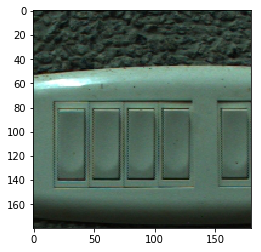

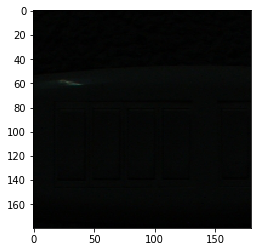

In [ ]:
obj_train = get_data(opt, transforms=trns)
dataloader_train = DataLoader(obj_train, batch_size=opt['batch_size'], shuffle=True, num_workers=2, pin_memory=True)

img = next(iter(dataloader_train))
print(img['imgs_op'].size())
print(img['imgs_ip_indv'].size())
print(img['imgs_ip_hid'].size())

plt.imshow(np.transpose(img['imgs_op'][0,0,...].numpy(),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(img['imgs_ip_indv'][0,0,0:3,...].numpy(),(1,2,0)))
#plt.imshow(np.transpose(img['imgs_ip_indv'][0,0,...].numpy(),(1,2,0)))
#plt.imshow(ycbcr2rgb(np.uint8(np.transpose(img['imgs_op_fixed'].numpy(),(1,2,0))*255)))

In [ ]:

class BasicBlock(nn.Module):
    
    def __init__(self):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = out + identity

        return out
    

        

In [ ]:
modellllz = []
for i in range(3):
    modellllz += [BasicBlock()]
print(modellllz)

[BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
), BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
), BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)]


In [ ]:
model_ft = BasicBlock()#models.resnet18(pretrained=True).layer2
model_ftt = BasicBlock()#models.resnet18(pretrained=True).layer2

hidd_res_block_list = []
        
res_blocks_list = []

for i in range(opt['indv_blocks']):
    res_blocks_list.append(BasicBlock())
    
    if i<opt['hidd_blocks']:
        hidd_res_block_list.append(BasicBlock())
    
res_blocks = nn.Sequential(*res_blocks_list)
hidd_res_blocks = nn.Sequential(*hidd_res_block_list)

print(res_blocks)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (2): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (4): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace)
    (conv2): Conv2

In [ ]:




class Unet(nn.Module):
    def __init__(self, res_blocks, hidd_res_blocks):
        super(Unet, self).__init__()
        
        self.conv_pre_process_ind = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=7, stride=1, padding=3, bias=True),
            #nn.BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(in_channels=15, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            #nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.ReLU(inplace=True)
        ) # 36,64,hw/2
        
        self.res_blocks = res_blocks
        self.hidd_res_blocks = hidd_res_blocks
        
        self.conv_pre_process_hidd = nn.Sequential(
            nn.Conv2d(in_channels=3*8*8, out_channels=64, kernel_size=7, stride=1, padding=3, bias=True),
            #nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            #nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.ReLU(inplace=True)
        ) # 1,128,hw/2
        
        self.conv_post_process_hidd = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        ) # 1,64,hw/2
         
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2,padding=0, output_padding=0),
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(inplace=True)
        )
        
        
    def forward(self, x, h):
        
        identity = x[:,:3,:,:].clone()
        
        
        
        h = self.conv_post_process_hidd(self.hidd_res_blocks(self.conv_pre_process_hidd(h)))
        #print(h.size())
        h = torch.cat([h]*x.size()[0])
        
        x = self.conv_pre_process_ind(x)
        x = self.res_blocks(torch.cat([x,h], dim=1))
        x = self.deconv(x) + identity
        
        return x
    
obj = Unet(res_blocks,hidd_res_blocks)
print(obj)

#img = obj(img['imgs_ip_indv'][0], img['imgs_ip_hid'][0])

#print(img.size())

#print(img.requires_grad)


Unet(
  (conv_pre_process_ind): Sequential(
    (0): Conv2d(15, 15, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): Conv2d(15, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (res_blocks): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (

In [ ]:
model = Unet(res_blocks,hidd_res_blocks)

In [ ]:
class common_functions():
    
    def __init__(self, opt, res_blocks,hidd_res_blocks):
        
        self.opt = opt
        self.train_loss = 100
        self.count = 0
                        
        self.device = torch.device("cuda")
        
        try:
            # Create target Directory
            os.mkdir(os.path.join(opt['save_dir'], opt['exp_name']))
            
            print("Directory Created") 
        except FileExistsError:
            print("Directory already exists")
        
        try:
            # Create target Directory
            os.mkdir(os.path.join(opt['save_dir'], opt['exp_name'], 'weights'))
            #os.mkdir(os.path.join(opt['save_dir'], opt['exp_name'], 'images'))
            print("Directories Created") 
        except FileExistsError:
            print("Directories already exists")
        
        
        model = Unet(res_blocks,hidd_res_blocks)
        
        self.model = model.to(self.device)
        #print(self.model)
        print(next(self.model.parameters()).is_cuda)  
        
        '''
        checkpoint = torch.load(os.path.join(opt['save_dir'], opt['exp_name'], 'weights', 'Real_four_high_mem_GoodModel_dark_scartch'))
        #print(checkpoint)
        self.model.load_state_dict(checkpoint['model'])
        '''

        # define loss functions
        self.criterion = torch.nn.L1Loss()  
        self.mseLoss = torch.nn.MSELoss() 

        # define optiizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.opt['lr'])
        #self.optimizer_wraper = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = self.optimizer, mode='max', factor=self.opt['gamma'], patience=self.opt['plateau_step'])
        #self.optimizer_wraper = torch.optim.lr_scheduler.StepLR(self.optimizer, self.opt['plateau_step'])
        self.optimizer.zero_grad()
        
        ##############################for vgg features
        
        model_ft = models.vgg19(pretrained=True)
        
        features = list(model_ft.features.children())[:19]
        
        features = nn.Sequential(*features)
        
        #self.features = nn.ModuleList(features).eval()
        
        print(features)
        self.features = features.to(self.device)
        
        self.features = self.features.eval()
        
        ###############################xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
        
        #######################################ssim
        self.window_size = 21
        sigma = 3
        gauss = torch.Tensor([exp(-(x - self.window_size//2)**2/float(2*sigma**2)) for x in range(self.window_size)])
        
        self.gauss = gauss/gauss.sum()
        
        self.channel = 3
        _1D_window = self.gauss.unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        
        self.window = Variable(_2D_window.expand(self.channel, 1, self.window_size, self.window_size).contiguous())
        
        self.window = self.window.to(self.device)
        
        
    def diff_ssim(self, img1, img2, size_average = True):
        
        self.window = self.window.type_as(img1)
        mu1 = F.conv2d(img1, self.window, padding = self.window_size//2, groups = self.channel)
        mu2 = F.conv2d(img2, self.window, padding = self.window_size//2, groups = self.channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1*mu2

        sigma1_sq = F.conv2d(img1*img1, self.window, padding = self.window_size//2, groups = self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2*img2, self.window, padding = self.window_size//2, groups = self.channel) - mu2_sq
        sigma12 = F.conv2d(img1*img2, self.window, padding = self.window_size//2, groups = self.channel) - mu1_mu2

        C1 = 0.01**2
        C2 = 0.03**2

        ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

        if size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)
        
        ########################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        
        ######################CONTEXTUAL
    def contextual_loss(self, x, y, h=0.5):
        """Computes contextual loss between x and y.

        Args:
          x: features of shape (N, C, H, W).
          y: features of shape (N, C, H, W).

        Returns:
          cx_loss = contextual loss between x and y (Eq (1) in the paper)
        """
        assert x.size() == y.size()
        N, C, H, W = x.size()   # e.g., 10 x 512 x 14 x 14. In this case, the number of points is 196 (14x14).

        y_mu = y.mean(3).mean(2).mean(0).reshape(1, -1, 1, 1)

        x_centered = x - y_mu
        y_centered = y - y_mu
        x_normalized = x_centered / torch.norm(x_centered, p=2, dim=1, keepdim=True)
        y_normalized = y_centered / torch.norm(y_centered, p=2, dim=1, keepdim=True)

        # The equation at the bottom of page 6 in the paper
        # Vectorized computation of cosine similarity for each pair of x_i and y_j
        x_normalized = x_normalized.reshape(N, C, -1)                                # (N, C, H*W)
        y_normalized = y_normalized.reshape(N, C, -1)                                # (N, C, H*W)
        cosine_sim = torch.bmm(x_normalized.transpose(1, 2), y_normalized)           # (N, H*W, H*W)

        d = 1 - cosine_sim                                  # (N, H*W, H*W)  d[n, i, j] means d_ij for n-th data 
        d_min, _ = torch.min(d, dim=2, keepdim=True)        # (N, H*W, 1)

        # Eq (2)
        d_tilde = d / (d_min + 1e-5)

        # Eq(3)
        w = torch.exp((1 - d_tilde) / h)

        # Eq(4)
        cx_ij = w / torch.sum(w, dim=2, keepdim=True)       # (N, H*W, H*W)

        # Eq (1)
        cx = torch.mean(torch.max(cx_ij, dim=1)[0], dim=1)  # (N, )
        cx_loss = torch.mean(-torch.log(cx + 1e-5))

        return cx_loss

        
    
    def vgg_features(self, x):
        results_out = []
        for ii, model in enumerate(self.features):
            model.requires_grad = False
            x = model(x)
            if ii in {9,13,18}:
                results_out.append(x)
                
        return results_out
    
    def full_contextual_loss(self, img1, img2):
        
        dict1 = self.vgg_features(img1)
        dict2 = self.vgg_features(img2)
        
        #loss_orig = self.contextual_loss(img1[choice,...], img2[choice,...])
        #loss_orig = self.contextual_loss(img1, img2)
        
        w = np.asarray([ 0.1, 0.15, 0.15])
        
        loss_features = 0
        for i in range(len({9,13,18})):
            loss_features = loss_features + w[i]*self.contextual_loss(dict1[i], dict2[i])
            
        return loss_features
        ################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        
        
        ########################BLURRED
    def blur_imgs_loss(self, img1, img2):
        
        self.window = self.window.type_as(img1)
        mu1 = F.conv2d(img1, self.window, padding = self.window_size//2, groups = self.channel)
        mu2 = F.conv2d(img2, self.window, padding = self.window_size//2, groups = self.channel)
        
        return self.mseLoss(mu1,mu2)
        ################################XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
  
    
    def optimize_parameters(self, imgs_ip, imgs_hd, imgs_op):
        
        imgs_ip = imgs_ip.to(self.device)
        imgs_hd = imgs_hd.to(self.device)
        imgs_op = imgs_op.to(self.device)
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        temp_loss = 0
        
        beg = time.time()
        
            
        pred_output = self.model(imgs_ip, imgs_hd)
        
        '''
        l1loss = self.criterion(imgs_op,pred_output)
        diff_ssim_loss = (1-self.diff_ssim(imgs_op, pred_output))
        
        if self.count<1500:
            flagg = False
            self.loss = 1*l1loss+0.5*diff_ssim_loss
        else:
            flagg = True
            self.loss = 0.6*l1loss+1.4*diff_ssim_loss
        '''  
        
        blurLoss = self.criterion(imgs_op,pred_output)#self.blur_imgs_loss(imgs_op, pred_output)
        
        
        cxLoss = self.full_contextual_loss(pred_output, imgs_op)
        
        #l1loss = self.criterion(imgs_op,pred_output)
        
        regularization_loss = 0
        for param in self.model.parameters():
            regularization_loss += torch.sum(torch.abs(param))
            
        
        if self.count<self.opt['when_reduce']:
            flagg = False
            self.loss =  5*blurLoss +  0.1*cxLoss + 1e-6*regularization_loss  
        else:
            flagg = True
            self.loss =  1*blurLoss +  0.1*cxLoss + 1e-6*regularization_loss
            if self.count%self.opt['text_prnt_freq']==0:
                print('Switched')
            
        self.loss.backward()
        
        self.optimizer.step()
            
        endd = time.time()
        
        #print(endd-beg)
        self.count +=1
        
        if self.count%self.opt['text_prnt_freq']==0:
            print('Count = {}, blurLoss = {:.5f}, cxLoss = {:.5f}, L1ref = {:.5f}'.format(self.count, blurLoss, cxLoss, 1e-5*regularization_loss))
            
            
            
        if self.count%opt['print_freq']==0:
            
            #print('Loss = {:.5f}'.format(self.loss.item()))
            plot_out_pred = torchvision.utils.make_grid(pred_output,nrow=8, padding=0, normalize=False)
            plot_out_pred = (np.clip(np.transpose(plot_out_pred.detach().cpu().numpy(),(1,2,0)),0,1)*255).astype(np.uint8)
            
            plot_out_GT = torchvision.utils.make_grid(imgs_op,nrow=8, padding=0, normalize=False)
            plot_out_GT = (np.clip(np.transpose(plot_out_GT.cpu().numpy(),(1,2,0)),0,1)*255).astype(np.uint8)
            
            plot_out_ip = torchvision.utils.make_grid(imgs_ip[:,:3,:,:],nrow=8, padding=0, normalize=False)
            plot_out_ip = (np.clip(np.transpose(plot_out_ip.cpu().numpy(),(1,2,0)),0,1)*255).astype(np.uint8)
            
            
            #print("Epoch: {0}, Views: {4}, Time: {1:.3f}, PSNR: {2:.3f}, SSIM: {3:.4f}, RMSE:{5:.4f}".format(self.count, endd-beg, 20*np.log10(np.max(plot_out_GT)) - 10*np.log10((np.mean(np.square((plot_out_pred-plot_out_GT))))),ssim(plot_out_pred,plot_out_GT,multichannel=True),64,np.sqrt(np.mean(np.square((plot_out_pred-plot_out_GT))))))            
            print("Epoch: {0}, Views: {4}, Time: {1:.3f}, PSNR: {2:.3f}, SSIM: {3:.4f}, RMSE:{5:.4f}".format(self.count, endd-beg, _PSNR(plot_out_GT,plot_out_pred),_SSIM(plot_out_pred,plot_out_GT,multichannel=True),64,_NRMSE(plot_out_GT,plot_out_pred)))
            
            print('Input:')
            plt.figure(figsize=(20,20))
                        
            plt.imshow(plot_out_ip)
            plt.show()
            
            print('Predicted Output:')
            plt.figure(figsize=(20,20))
                        
            plt.imshow(plot_out_pred)
            plt.show()
            
            print('GT:')
            
            
            plt.figure(figsize=(20,20))
            #plt.imshow(np.transpose(imgs_op[0,...].detach().cpu().numpy(),(1,2,0)))
            plt.imshow(plot_out_GT)
            plt.show()
            
        if self.count%opt['save_freq']==0:
            torch.save({'model': self.model.state_dict()}, os.path.join(opt['save_dir'], opt['exp_name'], 'weights', 'merged_data_1_VS_1_20_ind_deeper-flipping-L1reg-Color_jitter-{}'.format(self.count)))
                
            
            
                

In [ ]:
gan_model = common_functions(opt, res_blocks,hidd_res_blocks)

for epoch in range(opt['epochs']):
    for iteration, img in enumerate(dataloader_train):
        gan_model.optimize_parameters(img['imgs_ip_indv'][0],img['imgs_ip_hid'][0],img['imgs_op'][0])

